##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 0. Setup

ใน ep นี้ เราจะใช้ TensorFlow 2 ด้วยคำสั่ง Magic %tensorflow_version 2.x (สำหรับ Google Colab)

In [0]:
try:
    %tensorflow_version 2.x
except:
    pass

# 1. Import 

Import Library ที่เกี่ยวข้อง

In [41]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.1.0-rc1


# 2. Dataset

ชุดข้อมูลนี้สร้างจาก y = 5x + 0 บวก Noise อีกนิดหน่อย

In [0]:
x = [   -1,   0,  1,    2,     3,     4 ]
y = [ -5.1, 0.1,  5, 10.1,  14.9,  20.2 ]

# 3. Model

สร้างโมเดล Linear Regression ด้วย 1 Dense Layer ที่ไม่มี Activation Function

In [0]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=1, input_shape=[1])
])

ใช้ Mean Squared Error Loss Function และ Adam Optmizer

In [0]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1., beta_1=0.),
              loss='mean_squared_error')

# 4. Train

เทรนไป 20 Epoch

In [45]:
model.fit(x, y, epochs=20)

Train on 6 samples
Epoch 1/20
6/6 [==============================] - 0s 29ms/sample - loss: 200.0258
Epoch 2/20
6/6 [==============================] - 0s 1ms/sample - loss: 126.2419
Epoch 3/20
6/6 [==============================] - 0s 1ms/sample - loss: 76.9531
Epoch 4/20
6/6 [==============================] - 0s 1ms/sample - loss: 46.1516
Epoch 5/20
6/6 [==============================] - 0s 745us/sample - loss: 28.1457
Epoch 6/20
6/6 [==============================] - 0s 996us/sample - loss: 18.1603
Epoch 7/20
6/6 [==============================] - 0s 1ms/sample - loss: 12.7066
Epoch 8/20
6/6 [==============================] - 0s 1ms/sample - loss: 9.5826
Epoch 9/20
6/6 [==============================] - 0s 1ms/sample - loss: 7.5843
Epoch 10/20
6/6 [==============================] - 0s 1ms/sample - loss: 6.1350
Epoch 11/20
6/6 [==============================] - 0s 2ms/sample - loss: 4.9866
Epoch 12/20
6/6 [==============================] - 0s 2ms/sample - loss: 4.0387
Epoch 13/20
6/6 

# 5. Generate a SavedModel

เราจะ Export โมเดลในไฟล์ Format ใหม่ ของ TensorFlow ที่เรียกว่า SavedModel 

/1 คือ เลข Version

In [46]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


# 6. Convert the SavedModel to TFLite

แปลงโมเดลในไฟล์ SavedModel ไปเป็นไฟล์ tflite ที่เหมาะสำหรับใช้ในอุปกรณ์ Edge

In [0]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

Save ไฟล์ tflite ลง Disk เพื่อนำไปใส่อุปกรณ์ที่ต้องการต่อไป

In [48]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

792

ได้ไฟล์ขนาด 792 Byte

# 7. Initialize the TFLite Interpreter 

ในเคสนี้ เราจะลองรันโมเดล tflite ใน Notebook นี้เลย ให้เราโหลด TFLite Intepreter ขึ้นมา แล้วสั่งให้ Allocate Tensors เพื่อใช้เหมือนเป็น Emulator

In [0]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

ดึงข้อมูล Input และ Output ของ Intepreter / Model

In [0]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

เราจะวนลูป Random เรียก Intepreter 100 ครั้ง ด้วยค่า Input ต่าง ๆ ดูว่า Output จะเป็นอย่างไร

In [0]:
# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
inputs, outputs = [], []
for _ in range(100):
    input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
    interpreter.invoke()
    tflite_results = interpreter.get_tensor(output_details[0]['index'])
    
    # Test the TensorFlow model on random input data.
    tf_results = model(tf.constant(input_data))
    output_data = np.array(tf_results)
    
    inputs.append(input_data[0][0])
    outputs.append(output_data[0][0])

# 8. Visualize the Model

นำ Output ที่ได้มาพล็อตกราฟ จะได้เส้นตรง y = 5x + 0

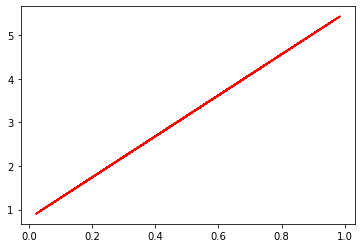

In [52]:
%matplotlib inline

plt.plot(inputs, outputs, 'r')
plt.show()

# 9. Download the TFLite Model File


ดาวน์โหลดไฟล์โมเดล เพื่อนำไปใส่ Edge Device ที่ต้องการ

In [0]:
try:
    from google.colab import files
    files.download(tflite_model_file)
except:
    pass

# 10. Credit

* https://www.coursera.org/learn/device-based-models-tensorflow/
* https://github.com/lmoroney/dlaicourse/tree/master/TensorFlow%20Deployment